In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

import os
import gzip
import json
import pickle
import pandas as pd

from serpapi import GoogleSearch
import statsmodels.formula.api as smf

In [4]:
def load_aggregated(aggregated_path="./data/aggregated.p"):
    if aggregated_path.endswith(".gz"):
        with gzip.open(aggregated_path, "rb") as f:
            agg = json.loads(f.read().decode())
    else:
        with open(aggregated_path, "rb") as f:
            agg = pickle.load(f)

    for k1, i1 in agg.items():
        for k2, i2 in agg[k1].items():
            if type(agg[k1][k2]) == pd.Series:
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif (type(agg[k1][k2]) == dict) and len(list(agg[k1][k2].keys())) > 100:
                agg[k1][k2] = pd.Series(agg[k1][k2])
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif type(agg[k1][k2]) == dict:
                for k3, i3 in agg[k1][k2].items():
                    if type(agg[k1][k2][k3]) == pd.Series:
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif (type(agg[k1][k2][k3]) == dict) and len(list(agg[k1][k2][k3].keys())) > 100:
                        agg[k1][k2][k3] = pd.Series(agg[k1][k2][k3])
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif type(agg[k1][k2][k3]) == dict:
                        for k4, i4 in agg[k1][k2][k3].items():
                            if type(agg[k1][k2][k3][k4]) == pd.Series:
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
                            elif (type(agg[k1][k2][k3][k4]) == dict) and len(list(agg[k1][k2][k3][k4].keys())) > 100:
                                agg[k1][k2][k3][k4] = pd.Series(agg[k1][k2][k3][k4])
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
    return agg


## Initial analysis
Making some plot to show how during the pandemic, as the mobility decreased, the online traffic increase, there should be a inverse correlation

In [5]:
# Importing mobility reports, 
google_df = pd.read_csv('./data/Global_Mobility_Report.csv.gz', compression="infer")

/tmp/ipykernel_81836/1902345458.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  google_df = pd.read_csv('./data/Global_Mobility_Report.csv.gz', compression="infer")


In [6]:
# We're only interested in the US, so we keep only the component about the US
mobility_us_df = google_df[google_df.country_region_code == 'US'].drop(columns=['country_region', 'country_region_code']).copy()
mobility_us_df['date'] = pd.to_datetime(mobility_us_df['date'])
# mobility_us_df = mobility_us_df.set_index('date')

# We're interested in the complete and states values, so we can discard the the values for which sub_region_2 is not null
mobility_us_df = mobility_us_df[mobility_us_df.sub_region_2.isna()].drop(columns=['sub_region_2','metro_area','iso_3166_2_code','census_fips_code'])

Interesting consideration, there is a difference between the change in mobility during the week (where people always go out for working) and during the weekend (where also normally people sometimes stay at home), this is clear looking at the daily plot, so it's beneficial to use the weekly one instead

In [7]:
general_df = mobility_us_df[(mobility_us_df.sub_region_1.isna()) & (mobility_us_df.date >= datetime(year=2020, month=2, day=15)) & (mobility_us_df.date <= datetime(year=2020, month=7, day=15))]
general_df = general_df[['date', 'residential_percent_change_from_baseline']]

weekday_general_df = general_df[general_df.date.dt.weekday <= 4].set_index('date')
weekend_general_df = general_df[general_df.date.dt.weekday > 4].set_index('date')

general_df = general_df.set_index('date')
weekly_general_df = general_df.resample('W-Mon').mean()

Now let's take the number of searches over time, we want to measure the total number of searches. One way to solve the problem is to make queries on different uncorrelated topics, the general consumption can be found by averaging the different topics.

In [8]:
# Import result from search
timeseries_dict = load_aggregated('./data/aggregated_timeseries.json.gz')

In [9]:
decrease_factor = ((np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                   - np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])) \
                   / np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])).mean()

In [10]:
total_searches_before = (np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                       + np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)] * (1 + decrease_factor))) / 2
total_searches_2020 = np.array(timeseries_dict['en']['sum'].loc[datetime(year=2020, month=2, day=15):datetime(year=2020, month=7, day=15)]) * (1 + decrease_factor)**2
total_searches_increase = 100 * (total_searches_2020 / total_searches_before - 1)

date_range = pd.date_range(datetime(year=2020, month=2, day=15), datetime(year=2020, month=7, day=15))

total_searches_increase = pd.DataFrame({'date': date_range, 'increase': total_searches_increase})#.set_index('date')
weekday_searches_increase = total_searches_increase[total_searches_increase.date.dt.weekday <= 4].set_index('date')
weekend_searches_increase = total_searches_increase[total_searches_increase.date.dt.weekday > 4].set_index('date')

total_searches_increase = total_searches_increase.set_index('date')
weekly_total_searches_increase = total_searches_increase.resample('W-Mon').mean()

Putting in context: the popularity of wikipedia from 2018 to 2020 has decreased, it can be seen by checking out the evolution of the weekly number of searches in the three years.

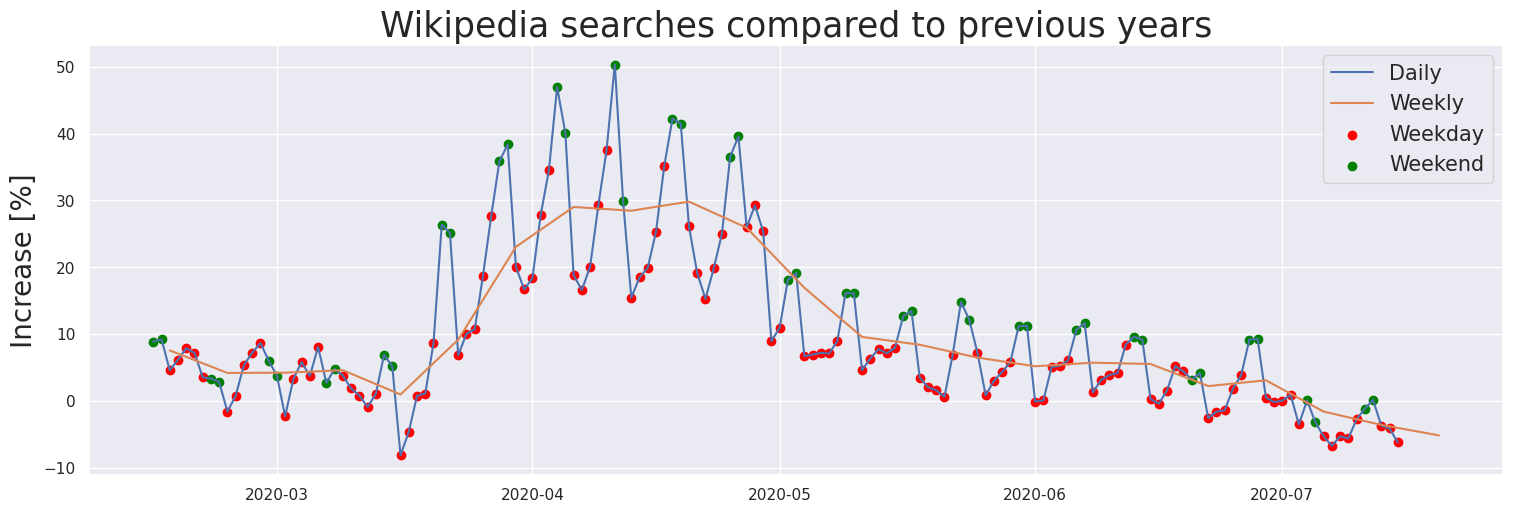

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
# fig.suptitle('Comparison between time spent at home and wikipedia searches between 2020 and previous years', size=20)
fig.tight_layout(h_pad=5)

# ax.set_title('Time at home compared to previous years', size=25)
# ax.set_ylabel('Increase [%]', size=20)
# # ax.set_xlabel('Date', size=15)
# ax.plot(general_df)
# ax.plot(weekly_general_df)
# ax.scatter(weekday_general_df.index, weekday_general_df, color='red')
# ax.scatter(weekend_general_df.index, weekend_general_df, color='green')
# ax.legend(['Daily', 'Weekly', 'Weekday', 'Weekend'], fontsize=15)

ax.set_title('Wikipedia searches compared to previous years', size=25)
ax.set_ylabel('Increase [%]', size=20)
# ax.set_xlabel('Date', size=15)
ax.plot(total_searches_increase)
ax.plot(weekly_total_searches_increase)
ax.scatter(weekday_searches_increase.index, weekday_searches_increase, color='red')
ax.scatter(weekend_searches_increase.index, weekend_searches_increase, color='green')
ax.legend(['Daily', 'Weekly', 'Weekday', 'Weekend'], fontsize=15)

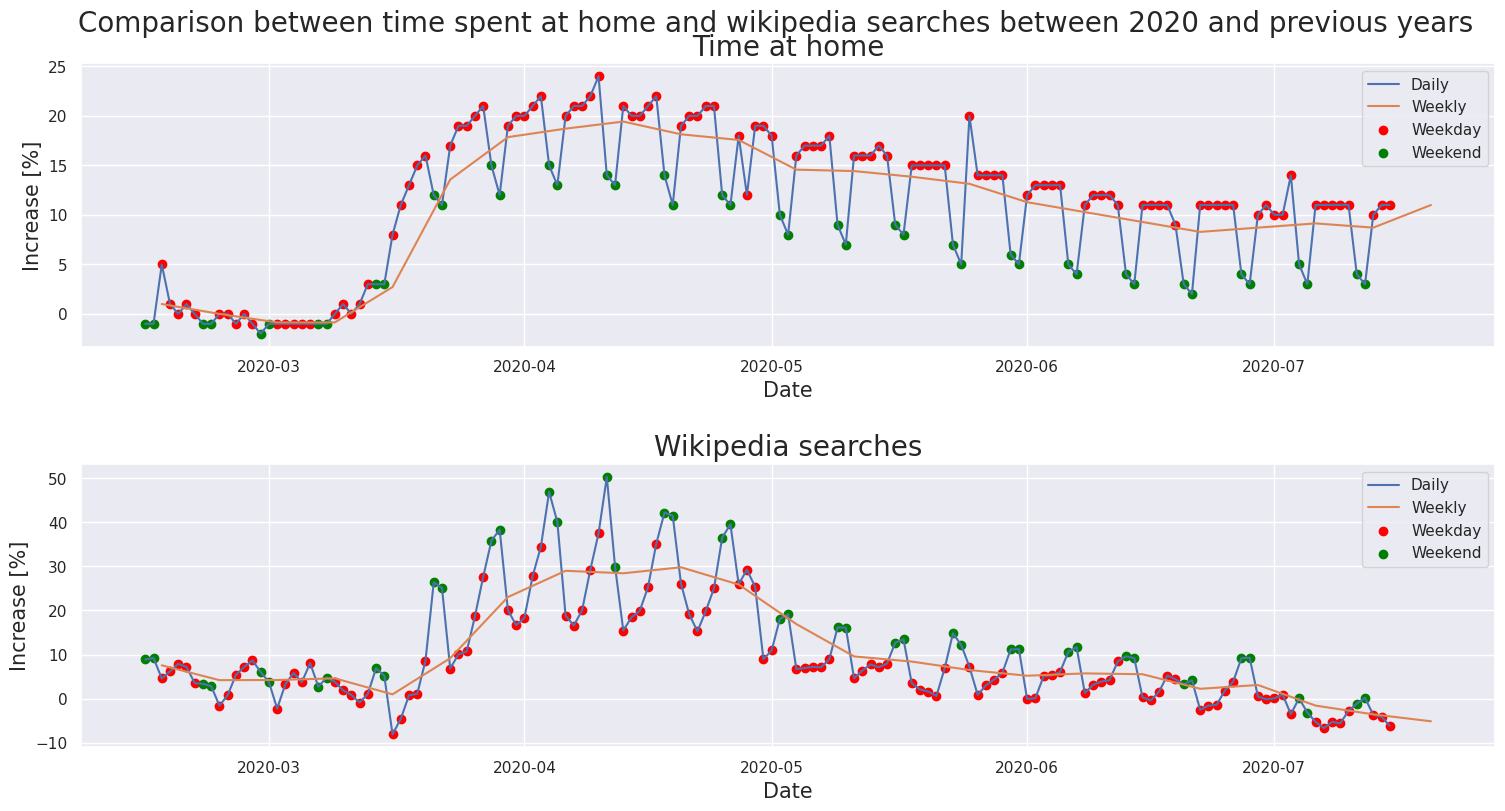

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=2)
fig.suptitle('Comparison between time spent at home and wikipedia searches between 2020 and previous years', size=20)
fig.tight_layout(h_pad=5)

ax[0].set_title('Time at home', size=20)
ax[0].set_ylabel('Increase [%]', size=15)
ax[0].set_xlabel('Date', size=15)
ax[0].plot(general_df)
ax[0].plot(weekly_general_df)
ax[0].scatter(weekday_general_df.index, weekday_general_df, color='red')
ax[0].scatter(weekend_general_df.index, weekend_general_df, color='green')
ax[0].legend(['Daily', 'Weekly', 'Weekday', 'Weekend'])

ax[1].set_title('Wikipedia searches', size=20)
ax[1].set_ylabel('Increase [%]', size=15)
ax[1].set_xlabel('Date', size=15)
ax[1].plot(total_searches_increase)
ax[1].plot(weekly_total_searches_increase)
ax[1].scatter(weekday_searches_increase.index, weekday_searches_increase, color='red')
ax[1].scatter(weekend_searches_increase.index, weekend_searches_increase, color='green')
ax[1].legend(['Daily', 'Weekly', 'Weekday', 'Weekend'])

In [13]:
# Getting OLS for day, week, weekdays and weekends
weekly_data = pd.DataFrame()
weekly_data['x'] = weekly_general_df
weekly_data['y'] = weekly_total_searches_increase

daily_data = pd.DataFrame()
daily_data['x'] = general_df
daily_data['y'] = weekly_total_searches_increase

weekday_data = pd.DataFrame()
weekday_data['x'] = weekday_general_df
weekday_data['y'] = weekday_searches_increase

weekend_data = pd.DataFrame()
weekend_data['x'] = weekend_general_df
weekend_data['y'] = weekend_searches_increase

# compute the different 
weekly_mod = smf.ols(formula='y ~ x', data=weekly_data)
daily_mod = smf.ols(formula='y ~ x', data=daily_data)
weekday_mod = smf.ols(formula='y ~ x', data=weekday_data)
weekend_mod = smf.ols(formula='y ~ x', data=weekend_data)

weekly_res = weekly_mod.fit()
daily_res = daily_mod.fit()
weekday_res = weekday_mod.fit()
weekend_res = weekend_mod.fit()

In [14]:
print(weekly_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     19.27
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           0.000256
Time:                        17:53:46   Log-Likelihood:                -78.975
No. Observations:                  23   AIC:                             161.9
Df Residuals:                      21   BIC:                             164.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4080      3.177     -0.758      0.4

In [15]:
print(daily_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     15.56
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           0.000802
Time:                        17:53:46   Log-Likelihood:                -75.812
No. Observations:                  22   AIC:                             155.6
Df Residuals:                      20   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2931      3.598     -0.637      0.5

Doing daily or weekly regressions give very similar results, both have good predictive power and similar coefficients (1.14 and 1.0).

In [16]:
print(weekday_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     55.08
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           3.03e-11
Time:                        17:53:46   Log-Likelihood:                -379.42
No. Observations:                 108   AIC:                             762.8
Df Residuals:                     106   BIC:                             768.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9873      1.628     -1.835      0.0

In [17]:
print(weekend_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     137.4
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           7.94e-15
Time:                        17:53:46   Log-Likelihood:                -148.24
No. Observations:                  44   AIC:                             300.5
Df Residuals:                      42   BIC:                             304.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9455      1.696      0.557      0.5

As expected, weekdays have a lower coefficient of 0.84, while weekends have a higher coefficient of 2.5192, this means that an increase in the time spent at home during the weekend is much more powerful than a weekday spent at home, for the number of Wikipedia searches done